<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import timm

## 常用功能

In [65]:


def read_data(directory, shift=0, termi=10) -> dict[str, np.array]:
    """Reads all the .nii files in a given directory and returns a dictionary.

    The dictionary keys are the file names without the .nii extension. The dictionary
    values are the corresponding numpy arrays.

    Args:
      directory: The directory containing the .nii files.
      shift: The number of files to skip at the beginning of the directory.
      termi: The number of files to be read in the directory.

    Returns:
      A dictionary of numpy arrays.
    """

    data_dict = {}
    k = 0
    ncut = 0
    filelist = os.listdir(directory)
    for afile in filelist:
      if afile.endswith('.nii'):
        if (k<shift):
          k += 1
          continue
        file_path = os.path.join(directory, afile)
        nii_file =  nib.load(file_path)
        data = nii_file.get_fdata()
        data_dict[afile.strip('.nii')] = data
        ncut +=  1
        if ncut == termi:
          return data_dict
    return data_dict



def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """

  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df



def process_data(data:dict, dflabel:pd.DataFrame)\
 -> tuple[torch.tensor, torch.tensor, list[tuple[str, int]]]:
  """Process the data, get the id and number of each scan, and merge the images and labels.

  Args:
      data: The data of the scans
      labels: The labels of the scans

  Returns:
      A tuple of images, labels, and (id, # of cuts) of each scan
  """

  # 每個scan的id與數量
  scans_info = []
  # 圖片與對應label的tesnor
  images_list = []
  labels_list = []

  if dflabel.index.name != 'id':
    dflabel.set_index('id', inplace=True)
  for key, value in data.items():
    scans_info.append((key, value.shape[2]))
    scan  = dflabel.loc[dflabel.index.str.startswith(key+'_')]
    labels = np.array(scan['label'])

    images_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)
    labels_t = torch.from_numpy(labels)
    images_list.append(images_t)
    labels_list.append(labels_t)

  # 合併
  images = torch.cat(images_list, dim=0)
  labels = torch.cat(labels_list, dim=0)
  print(f"read {len(scans_info)} scans")

  return images, labels.float(), scans_info


def argumenting(images, labels, n=5):
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels



def get_confusion(guess, truth):
  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)



def print_results(prediction, labels):
  if torch.is_tensor(prediction):
    prediction = prediction.cpu().numpy()
  if torch.is_tensor(labels):
    labels = labels.cpu().numpy()

  TP,FP,FN,TN = get_confusion(prediction, labels)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  print(f"{recall=}\n{precision=}\n{F1=}\n")



def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [4]:
device = isgpu()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 路徑


In [14]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [7]:
!pwd

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [8]:
os.listdir('TrainValid_Image/train_data')

['ZxA587DD3F3B7DEFF324487D39123C2C626E291DCF7376E42D.nii',
 'ZxD4CF37EF147DDEE980BAB4F5256CC86CA734F199E5512303.nii',
 'ZxBE2A252CBA88052F4A6B548249B9D70F14E4552A09EFAC38.nii',
 'ZxEACFC663D819866E172E1DD2EC69EF67339C975F9A23A451.nii',
 'Zx9FAE5E8EE578A076D0A2FB260477EAC119844611FEE70C48.nii',
 'ZxBCBA63BCCC1F7498AA92F4AF08511FFED09105BBFC63864E.nii',
 'Zx95F33E17F7F8218E9FA35FC3D79D8EB9E02019709C3A5EC2.nii',
 'Zx808CBF85580C8A52F625D7FC9667F12DA964A7194E5A900F.nii',
 'ZxE379608F86D71DD9A2EE5FE1F9BCA94B1526AF3E1F5D036D.nii',
 'ZxD8736DEB1A7AFA67733E095769BBD236FFAD5150198E5109.nii',
 'Zx9D76C42817583BCA25AF1F14469B372700E105BFC7452D78.nii',
 'Zx8104110A401AA0F1936937E0C991C0560D0BD7A52FA5AD62.nii',
 'Zx97E643B8E4A5DEB351E18CB763B8CFB27D5A870812A6C453.nii',
 'ZxD4CE4B3B95995BE6E2E7864BDCEBFCDCF32B2C8F5579C682.nii',
 'ZxE7279474581D135218F20333FE314E94583F697B1F36C9A1.nii',
 'Zx7D5AB573090376F781DC164A66E6BDA1FA3E4F8D8AEDF9EE.nii',
 'ZxC7F93D23D81997D7158951EDAAC448DE709828F562E63B5C.nii

# 處理資料

In [41]:
# data = read_data(dir,termi=10,shift=0)
# dflabel = read_label("TrainValid_ground_truth.csv")
dir = 'TrainValid_Image/train_data'
images = []
labels = []
info = []
for i in range(len(os.listdir(dir))-990):
  data = read_data(dir,termi=1,shift=i)
  label_ = read_label("TrainValid_ground_truth.csv")
  image_, label_, info_ = process_data(data, label_)
  image_ ,label_ = remove_false_images(image_, label_, 0.8)
  images.append(image_)
  labels.append(label_)
  info.append(info_)

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)

read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans
read 1 scans


In [ ]:
# images,labels, _ = process_data(data,dflabel)

read 10 scans


In [ ]:
# images,labels = argumenting(images,labels,3)

In [ ]:
images.shape

torch.Size([1186, 1, 512, 512])

# 訓練 (Unet with only encoder)

In [ ]:
class FC(nn.Module):
    def __init__(self, in_channels):
        super(FC, self).__init__()

        # Encoder部分
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),  # Add BatchNorm after the first Conv2d
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm after the first Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm after the second Conv2d
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm after the third Conv2d
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Add BatchNorm after the fourth Conv2d
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(128 * 128 * 256, 1)  # x 和 y 是經過 encoder 處理後的特徵圖尺寸


    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
model_name = "tf_efficientnetv2_m"
pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)

# 檢查模型結構
# print(pretrained_model)


model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

## 訓練 (EfficiencyNetV2_m)

In [ ]:
from torch.utils.data import Dataset, DataLoader
num_epochs = 10
batch_size = 6
lr = 0.01
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄
# 初始化模型、損失函數和優化器
# model = FC(in_channels=1).to(device)
model = pretrained_model


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
model.to(device)

running_loss_list = []
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Assuming you have 'images' and 'labels' as your original data
dataset = CustomDataset(images, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss_list.append(running_loss/len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

Epoch 1, Loss: 0.6892902344992065
Epoch 2, Loss: 0.5260309427976608
Epoch 3, Loss: 0.5375717449368853
Epoch 4, Loss: 0.5297584029460194
Epoch 5, Loss: 0.5258645102983773
Epoch 6, Loss: 0.48065465440352756
Epoch 7, Loss: 0.4733349070555032
Epoch 8, Loss: 0.4983966625624835
Epoch 9, Loss: 0.4779242980058747
Epoch 10, Loss: 0.47085807733990326


In [ ]:
num_epochs = 10
batch_size = 16
lr = 0.001
num_batches = len(images) // batch_size  #最後data不滿一個batch丟棄
# 初始化模型、損失函數和優化器
model = FC(in_channels=1).to(device)
# model = pretrained_model


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

running_loss_list = []

# 訓練循環
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = labels[i*batch_size:(i+1)*batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss_list.append(running_loss/num_batches)
    print(f"Epoch {epoch+1}, Loss: {running_loss/num_batches}")


# Loss圖

Text(0, 0.5, 'Loss')

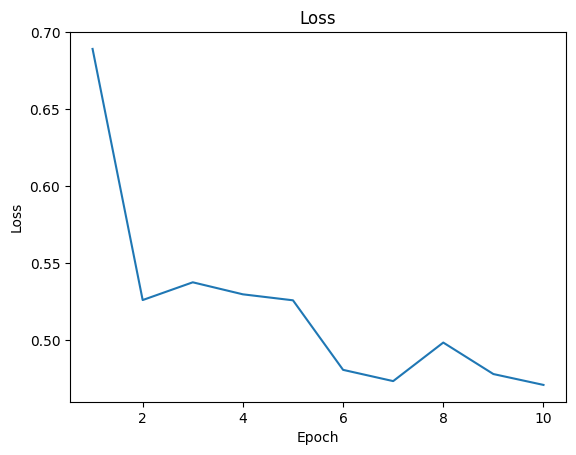

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,num_epochs+1)[:len(running_loss_list)], running_loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 儲存模型參數



In [ ]:
cd /content/drive/MyDrive/AOCR2024

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


In [ ]:
import json
appendix = input("請輸入模型儲存的檔名:")
dirname = input("請輸入模型儲存的資料夾:")
filename = f"params/{dirname}/{appendix}"
if not os.path.exists(dirname):
  os.mkdir(dirname)

if os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth exist.")
else:
    torch.save(model.state_dict(), f'{filename}.pth')

params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': lr,
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

請輸入要儲存的編號:2


# 讀取模型參數

In [ ]:
# model = pretrained_model
# model.to(device)

In [ ]:
import json
filename = input("請輸入要獲取模型路徑:")

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))

with open(f'{filename}.json', 'r') as f:
    params = json.load(f)


請輸入要獲取模型檔名:Sequential2


# 評估


In [ ]:
data = read_data("TrainValid_Image/train_data",termi=80,shift=80)
# data = read_data("Test1_Image/test_data",termi=3,shift=1)
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
images,labels,info = process_data(data, dflabel)

read 3 scans


In [ ]:
# 評估設置
num_epochs = params['num_epochs']
batch_size = params['batch_size']

#最後data不滿一個batch
num_batches = len(images) // batch_size
if len(images) % batch_size != 0:
  num_batches += 1

In [ ]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    correct = 0
    total = 0
    for i in range(num_batches):
        batch_images = images[i*batch_size:(i+1)*batch_size].to(device)
        batch_labels = labels[i*batch_size:(i+1)*batch_size].to(device)

        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()
        if predicted.dim() == 0:
          predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()



In [ ]:
print_results(predict_listq, labels[:len(predict_list)])

# 輸出至submission.csv

In [ ]:
def cont(l):
  "1是否連續"
  f1 = False
  f2 = False
  for i in range(len(l)):
    if (l[i] == 1):
      f1 = True
    if (l[i] == 0):
      if (f1):
        f2 = True
    if (l[i] == 1) and f2:
      return False
  return True

def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
# import pdb
# pdb.set_trace()
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
filename = input("輸入提交檔名(enter for submission)")
if filename == '':
  filename = 'submission'
dfout.to_csv(filename+'.csv', index=False)

In [ ]:
info

[('Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F33381', 97),
 ('Zx856FBE2C71AFB86C6974EBD23B9878ED38822BCA17B456F0', 101),
 ('Zx48074DB9E0145933E2EED0A7E4EB0D3B0A9447A110736D8D', 105)]

In [ ]:
dfout

,id,label
96,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,0
0,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,1
1,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,1
2,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,1
3,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,1
...,...,...
91,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,0
92,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,0
93,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,0
94,Zx3E443FFD3162E0841D1B1867408C7E72C62DF2C248F3...,0


# 其他

In [70]:
!pwd

/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


查看submission files

In [71]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [72]:
len(dftest)

7568

In [73]:
import re

# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.to_series().str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [74]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

==========F1 score on scan level==========

      真實值
  預  +-----+-----+
  測| TP: 78| FP: 0|
  值| FN: 2| TN: 0|
      +-----+-----+ 

recall=0.975
precision=1.0
F1=0.9873417721518987



==========F1 score on cut level==========

      真實值
  預  +-----+-----+
  測| TP: 564| FP: 189|
  值| FN: 123| TN: 6612|
      +-----+-----+ 

recall=0.8209606986899564
precision=0.749003984063745
F1=0.7833333333333334

